# Autoencoder for getting vector embeddings

**Advisor:** Marcos M. Raimundo <br>
**Co-Advisor:** Thalita Veronese <br>
**Student:** João Victor P. B. Avanzini

## Imports

In [1]:
import tensorflow as tf
import os

import neurokit2 as nk


import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Input, Conv1DTranspose, Conv2DTranspose, Reshape
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
import tensorflow as tf

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

2023-12-06 13:18:31.374241: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 13:18:31.374418: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 13:18:31.439732: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 13:18:31.576181: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 13:18:32.966082: W tensorflow/compiler/tf2

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:04:00.0, compute capability: 5.2
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:05:00.0, compute capability: 5.2



2023-12-06 13:18:35.881583: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11602 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:04:00.0, compute capability: 5.2
2023-12-06 13:18:35.882985: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11601 MB memory:  -> device: 1, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:05:00.0, compute capability: 5.2


## 30 Subjects of single ECG autoencoder

In [12]:
subjects = pd.read_csv('../data/merged_ecg_data.csv')
subjects = subjects[:39000000]

In [13]:
subjects.shape

(39000000, 1)

In [14]:
subjects_reshaped = subjects.values.reshape((1300, 30000, 1))
subjects_reshaped.shape

(1300, 30000, 1)

## 30 Subjects ECG autoencoder

In [15]:
encoder = tf.keras.models.Sequential([
    Conv1D(64, 1300, activation='relu', padding='same', input_shape=(30000, 1)),
    Dense(32, activation='relu'),
    MaxPooling1D(),
    Conv1D(32, 1300, activation='relu', padding='same'),
    Dense(16, activation='relu'),
    MaxPooling1D(),
    Flatten(),
    Dense(8)
    
], name='encoder')

2023-12-06 13:44:53.875713: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11602 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:04:00.0, compute capability: 5.2
2023-12-06 13:44:53.876176: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11601 MB memory:  -> device: 1, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:05:00.0, compute capability: 5.2


In [16]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30000, 64)         83264     
                                                                 
 dense (Dense)               (None, 30000, 32)         2080      
                                                                 
 max_pooling1d (MaxPooling1  (None, 15000, 32)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 15000, 32)         1331232   
                                                                 
 dense_1 (Dense)             (None, 15000, 16)         528       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 7500, 16)          0         
 g1D)                                                      

In [17]:
decoder = tf.keras.models.Sequential([
    Reshape((8, 1)),
    Conv1DTranspose(8, 29993, activation='relu', input_shape=(8, 1)),
    Dense(16, activation='relu'),
    Conv1DTranspose(16, 1300, activation='relu', padding='same'),
    Dense(32, activation='relu'),
    Conv1DTranspose(32, 1300, activation='relu', padding='same'),
    Dense(64, activation='relu'),
    Conv1DTranspose(1, 1300, activation='relu', padding='same'),
], name='decoder')

In [22]:
#decoder.summary()

In [18]:
autoencoder = Sequential([encoder, decoder])
autoencoder.summary(expand_nested=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 8)                 2377112   
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv1d (Conv1D)            (None, 30000, 64)         83264    |
|                                                               |
| dense (Dense)              (None, 30000, 32)         2080     |
|                                                               |
| max_pooling1d (MaxPooling  (None, 15000, 32)         0        |
| 1D)                                                           |
|                                                               |
| conv1d_1 (Conv1D)          (None, 15000, 32)         1331232  |
|                                                               |
| dense_1 (Dense)            (None, 15000, 16)         528      |
|                                                       

In [ ]:
autoencoder.compile(optimizer = "adam", loss = "mse")
history = autoencoder.fit(subjects_reshaped, subjects_reshaped, batch_size = 128, epochs = 10, verbose = 0, callbacks=[TqdmCallback(verbose=1)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2023-12-06 13:45:32.559741: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-06 13:47:45.058920: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff9b01912f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-06 13:47:45.058949: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2023-12-06 13:47:45.058955: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2023-12-06 13:47:45.076298: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1701870465.198446    1693 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


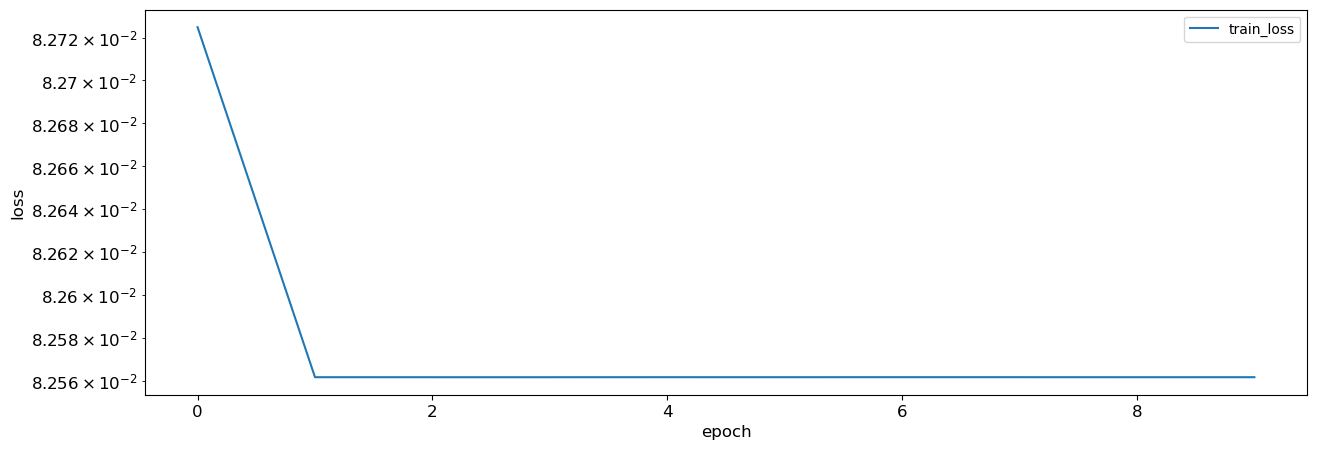

In [24]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

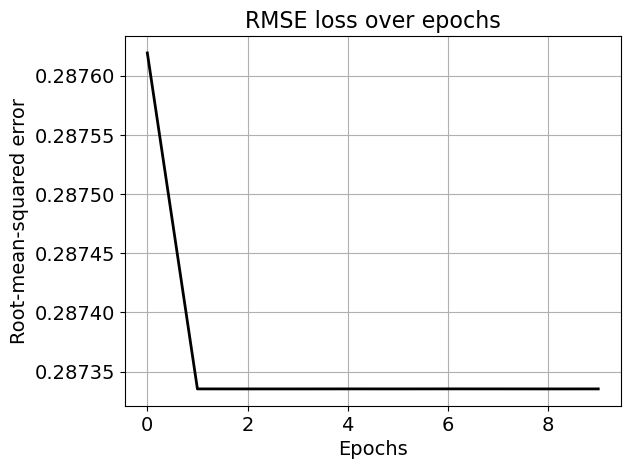

In [25]:
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(history.history['loss']), label='Training RMSE', c='k', lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [26]:
print("Epoch\tRMSE")
for epoch, rmse in enumerate(np.sqrt(history.history['loss'])):
    print(f"{epoch}\t{rmse}")

Epoch	RMSE
0	0.2876192612620525
1	0.28733543008496953
2	0.2873354171200164
3	0.2873354171200164
4	0.2873354430499221
5	0.28733543008496953
6	0.28733545601487404
7	0.2873354430499221
8	0.2873354171200164
9	0.28733543008496953


## Inference process

In [61]:
def process_subject(ax, subject_number):
    file_path = f'../data/output_blobs_case_{subject_number}_merged.csv'
    
    subject_data = pd.read_csv(file_path)
    
    subject_data = subject_data[:300000]
    
    subject_data = subject_data.values.reshape((10, 30000, 1))
    
    encoder_embeddings = encoder.predict(subject_data)
    
    ax.plot(encoder_embeddings)
    ax.set_title(f'Subject {subject_number}')
    
    return encoder_embeddings.flatten()

1/1 [==============================] - 0s 167ms/step


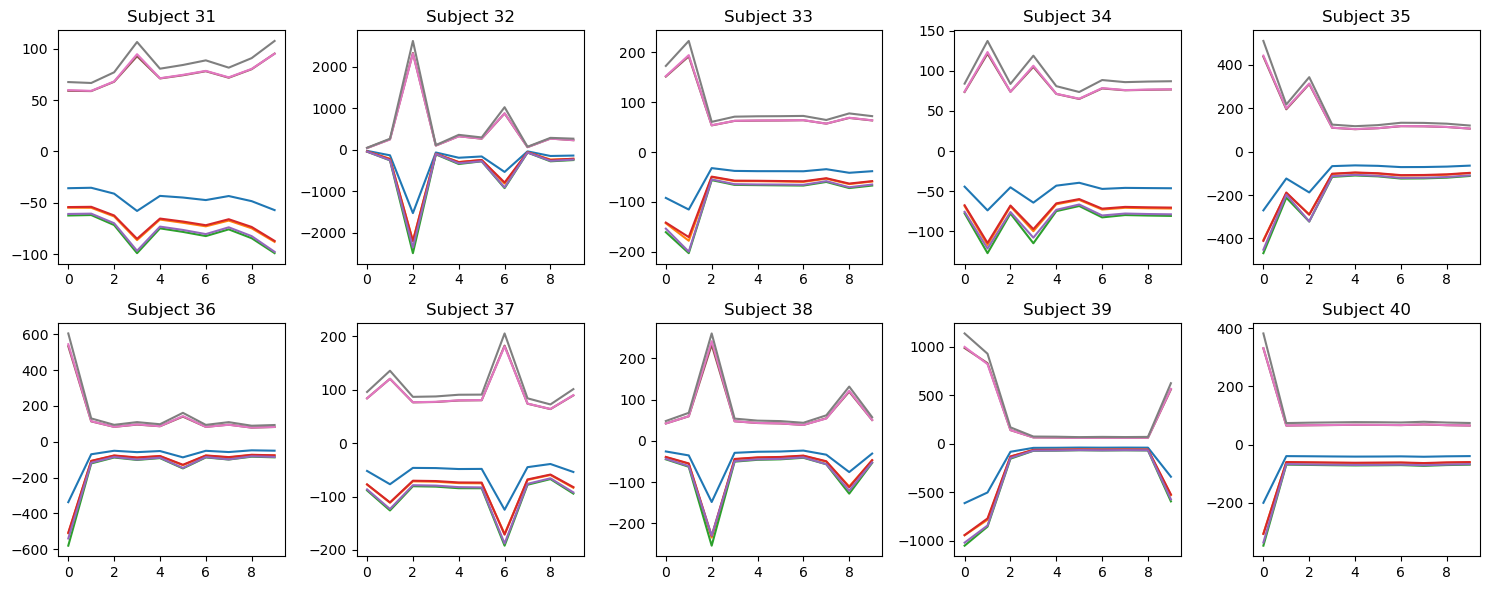

In [62]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

embeddings_list = []
for ax, subject_number in zip(axes.flatten(), range(31, 42)):
    embeddings = process_subject(ax, subject_number)
    embeddings_list.append(embeddings)

plt.tight_layout()
plt.show()

In [63]:
embeddings_df = pd.DataFrame(embeddings_list)
embeddings_df.to_csv('encoder_embeddings.csv', index=False)